## Imports, etc.

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import datetime 
import os
import pandas as pd

from plotnine import *

/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [3]:
import snowflake.connector

conn = snowflake.connector.connect(
        user=os.environ["SNOWFLAKE_USER"],
        password=os.environ["SNOWFLAKE_PASSWORD"],
        account=os.environ["SNOWFLAKE_ACCOUNT"],
    )

In [4]:
def pq(qry,conn=conn):
    qry = qry.replace('from ','from predict.')
    return pd.read_sql(qry,conn)

## Basil

In [ ]:
COMPONENT_ID = "15"

### 4/1/22 - 6/1/22

In [ ]:
START_DATE = '2022-04-01'
END_DATE = '2022-06-01'

In [5]:
# Computed actuals
qry = f"""
    select * 
    from m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = pq(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,PREDICTED_SHORTFALL_LBS_Q90,SHORTFALL_PROBABILITY,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION
0,1,2022-05-28,None,15,Basil,75.09375,7.923420,88.022581,6.974399,28.59375,...,-44.97,0.01,2022-05-28 23:16:20,2022-05-28 19:16:20,None,None,None,a9aa0040-a654-5d3b-b387-5b4c09921ad9,False,True
1,1,2022-04-25,None,15,Basil,165.09375,3.430396,87.534516,3.002780,58.12500,...,-18.28,0.07,2022-04-25 20:16:18,2022-04-25 16:16:18,None,None,None,8a1e2d50-4707-5831-9b2e-77b1432e651f,True,True
2,2,2022-05-16,None,15,Basil,479.06250,0.000000,69.202258,0.000000,NaN,...,-158.02,0.00,2022-05-16 23:16:27,2022-05-16 19:16:27,None,None,None,54ba5eaa-04b8-5bab-9324-0456d96a5472,False,True


In [6]:


qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select farm_id, 
          delivery_scheduled_on,
          weight_to_allocate_lbs,
          weight_allocated_lbs,
          (weight_to_allocate_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items
        inner join sku_formulations using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select farm_id,
      delivery_scheduled_on,
      sum(shortfall) as shortfall_lbs
    from line_item_status
    group by farm_id, delivery_scheduled_on
"""

line_items_allocated_weight = pd.read_sql(qry,conn)

line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,SHORTFALL_LBS
0,2,2022-04-20,0.0
1,2,2022-05-03,0.0
2,2,2022-04-06,0.0
3,1,2022-05-23,0.0
4,2,2022-04-25,0.0


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:396: PlotnineWarning: If you need more space for the y-axis tick text use ... + theme(subplots_adjust={'hspace': 0.25}). Choose an appropriate value for 'hspace'
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 4 rows containing missing values.


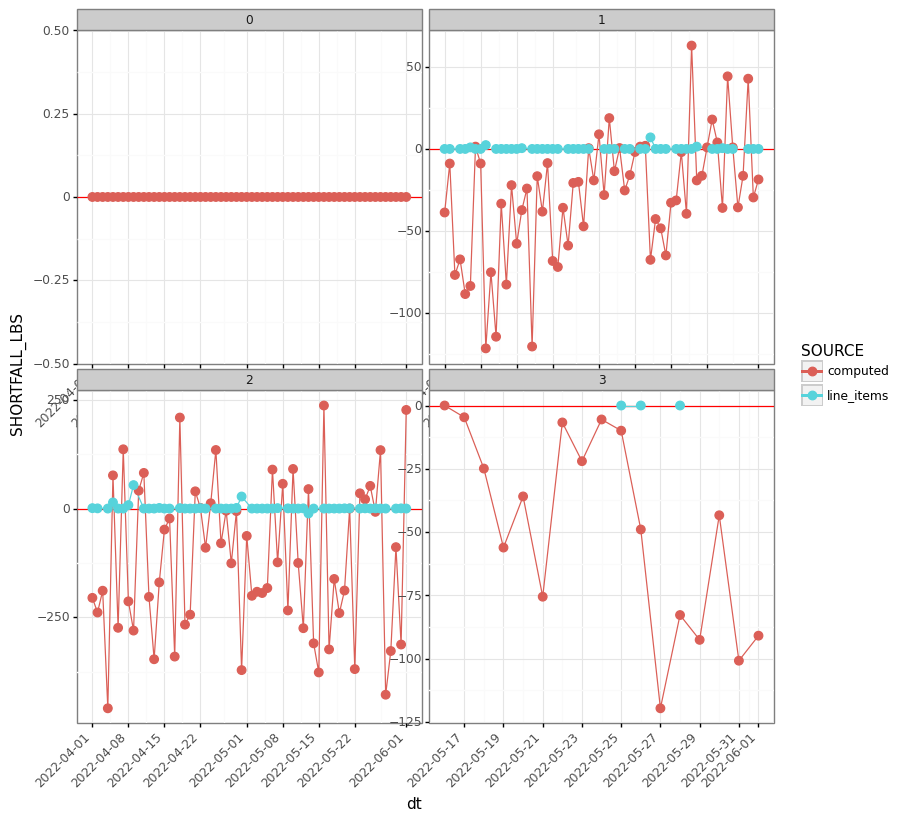

<ggplot: (357970676)>

In [10]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('FARM_ID', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
          
         )
)

### 1/1/21 - 12/13/21

In [12]:
START_DATE = '2021-01-01'
END_DATE = '2021-12-31'

In [13]:
# Computed actuals
qry = f"""
    select * 
    from m_inflight_fulfillment
    where component_id = {COMPONENT_ID}
    and fact_date between '{START_DATE}' and '{END_DATE}'
    and is_latest_prediction = True
"""

computed_actuals = pq(qry)
computed_actuals.head(n=3)

,FARM_ID,FACT_DATE,REFERENCE_DATE,COMPONENT_ID,COMPONENT_NAME,CASE_INVENTORY_LBS,BIN_INVENTORY_LBS,RECENT_HARVEST_TO_PACK_PCT,BIN_INVENTORY_PACKED_ESTIMATION_LBS,PACKED_LBS,...,PREDICTED_SHORTFALL_LBS_Q90,SHORTFALL_PROBABILITY,COMPUTED_AT,COMPUTED_AT_LOCAL,PREDICTION_DAYS_AHEAD,CODE_VERSION,GIT_SHA,MESSAGE_ID,IS_WITHIN_BOUNDS,IS_LATEST_PREDICTION
0,0,2021-03-14,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
1,0,2021-12-30,None,15,Basil,NaN,5.809185,NaN,NaN,NaN,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True
2,1,2021-10-21,None,15,Basil,125.15625,1.763700,88.216774,1.555879,144.866998,...,NaN,NaN,NaT,NaT,NaN,None,None,None,None,True


In [14]:
qry = f"""
    with basil_formulations as (
        select formulation_id
        from warehouse.br_formulation_to_component
        where component_id = {COMPONENT_ID}
    ),
    sold_skus as (
        select distinct sku_id
        from warehouse.dm_line_items
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    ),
    sku_formulations as (
        select distinct sku_id, sku_name, formulation_id
        from warehouse.dm_skus
        inner join basil_formulations using (formulation_id)
    ),
    line_item_status as (
        select farm_id, 
          delivery_scheduled_on,
          weight_to_allocate_lbs,
          weight_allocated_lbs,
          (weight_to_allocate_lbs - weight_allocated_lbs) as shortfall
        from warehouse.dm_line_items
        inner join sku_formulations using (sku_id)
        where delivery_scheduled_on between '{START_DATE}' and '{END_DATE}'
    )
    select farm_id,
      delivery_scheduled_on,
      sum(shortfall) as shortfall_lbs
    from line_item_status
    group by farm_id, delivery_scheduled_on
"""

line_items_allocated_weight = pd.read_sql(qry,conn)

line_items_allocated_weight.head()

,FARM_ID,DELIVERY_SCHEDULED_ON,SHORTFALL_LBS
0,1,2021-05-18,0.00000
1,1,2021-08-09,1.40625
2,2,2021-08-02,0.00000
3,1,2021-02-25,0.00000
4,2,2021-10-07,0.00000


/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/facets/facet.py:390: PlotnineWarning: If you need more space for the x-axis tick text use ... + theme(subplots_adjust={'wspace': 0.25}). Choose an appropriate value for 'wspace'.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 1 rows containing missing values.
/Users/pmccarthy/git/inflight_fulfillment/venv/lib/python3.9/site-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 47 rows containing missing values.


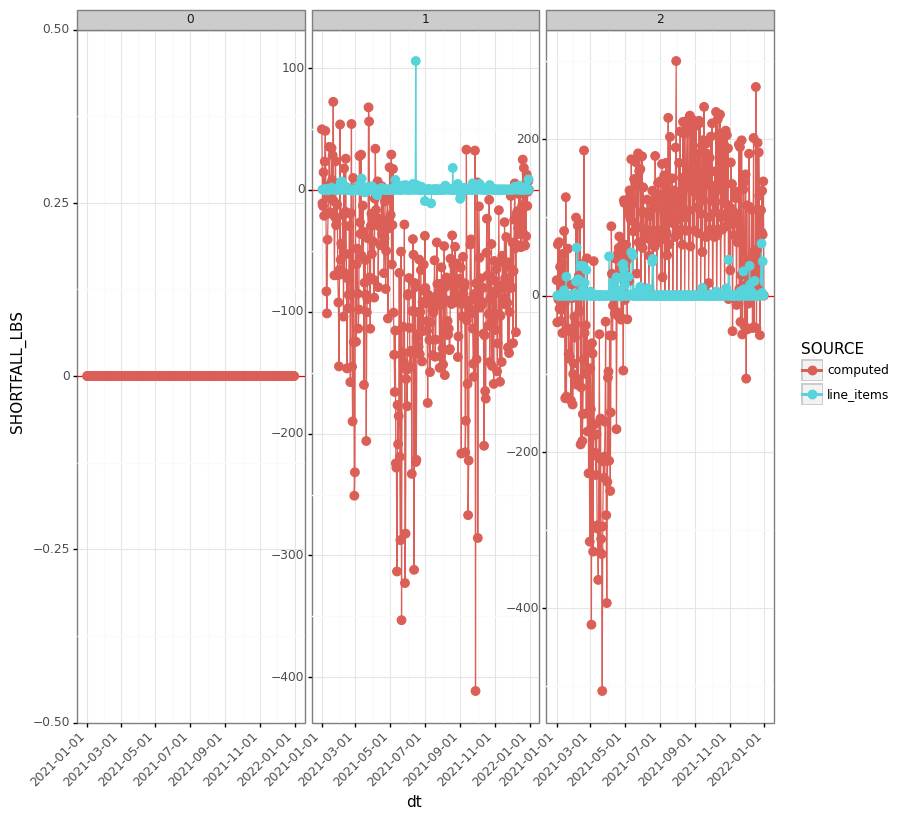

<ggplot: (359939572)>

In [17]:
(
    computed_actuals.filter(items=['FARM_ID','FACT_DATE','SHORTFALL_LBS'])
    .assign(SOURCE = 'computed')
    .pipe(lambda x: pd.concat([x,
                               line_items_allocated_weight.rename(columns={'DELIVERY_SCHEDULED_ON':'FACT_DATE'})
                               .assign(SOURCE = 'line_items')],axis=0))
    .assign(dt = lambda x: pd.to_datetime(x['FACT_DATE']))
    .pipe(lambda frame: ggplot(frame, aes(x='dt',y='SHORTFALL_LBS',color='SOURCE'))
          + geom_hline(yintercept=0,color='red')
          + geom_line()
          + geom_point(size=3)
          + facet_wrap('FARM_ID', scales='free')
          + theme_bw()
          + theme(axis_text_x=element_text(hjust=1,rotation=45), figure_size=(9,9))
         )
)